# CS440/ECE448 Spring 2024
# MP05: Neural Networks

This tutorial and its materials are based on and adapted from the [PyTorch Official Tutorial](https://pytorch.org/tutorials/) and [mrdbourke/pytorch-deep-learning](https://www.learnpytorch.io/), revised to meet the requirements of this assignment.

We encourage you to explore the original tutorials for additional topics not covered in this assignment.

This notebook will walk you through the whole MP, giving you instructions and debugging tips as you go.

If you are already familiar with PyTorch, you can jump to the **implement this** sections.

<a id='section0'></a>
## Goal

The goal of this assignment is to employ neural networks, nonlinear and multi-layer extensions of the linear perceptron, to classify images into `5 categories`:
- ship (0)
- automobile (1)
- dog (2)
- frog (3)
- horse (4)

## Table of Contents

1. <a href="#section0">Goal</a>
1. <a href="#section1">What is PyTorch</a>
1. <a href="#section2">Datasets</a>
1. <a href="#section3">Dataloaders</a>
1. <a href="#section4">Tensors</a>
1. <a href="#section5">Neural Net Layers</a>
1. <a href="#section6">You need to implement this (1)</a>
1. <a href="#section7">Build a Model</a>
1. <a href="#section8">Train a Model</a>
1. <a href="#section9">You need to implement this (2)</a>
1. <a href="#section10">Gradients</a>
1. <a href="#section11">You need to implement this (3)</a>
1. <a href="#extra">Extra Credit</a>

<a id='section1'></a>
## What is *__PyTorch__*?
*PyTorch* is an open source machine learning framework that accelerates the path from research prototyping to production deployment.  
*PyTorch* allows you to manipulate and process data and write machine learning algorithms using Python code (user-friendly!).  
*PyTorch* also offers some domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html), [TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html).

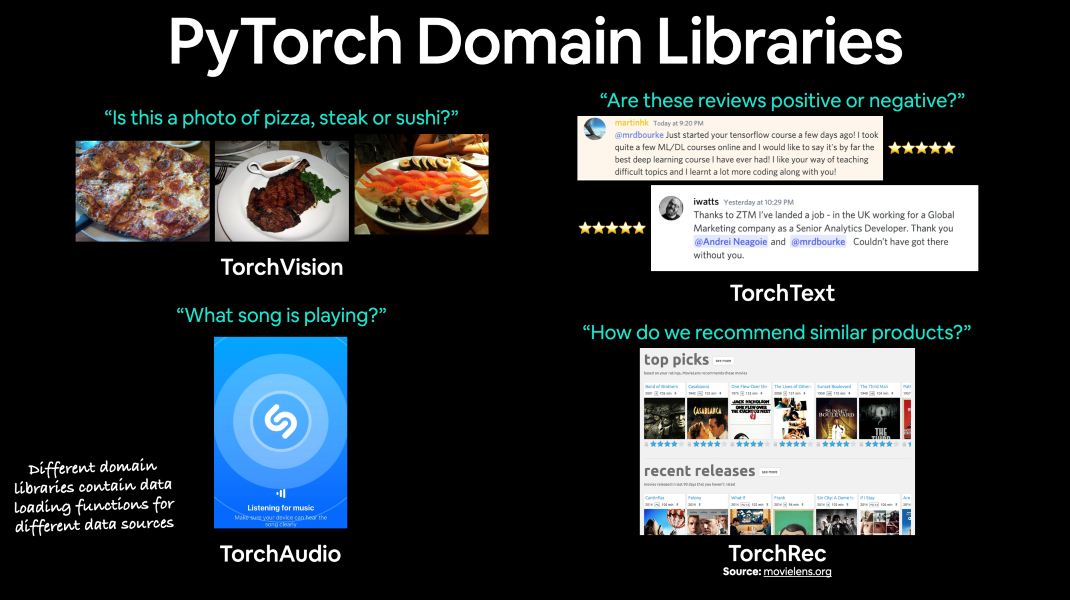

You can [install *PyTorch*](https://pytorch.org/get-started/locally/) with conda or pip.  
The exact installation command varies based on your system setup and desired *PyTorch* version. For example, to install *PyTorch* with pip, you can use the following command:

```bash
pip install torch
```

For this assignment, **GPU support is not required** since the autograder doesn't have any GPUs. Therefore, you can install *PyTorch* without CUDA support. However, learning how to use *PyTorch* with CUDA might be beneficial for your future projects.


Let's verify the installation by printing *PyTorch* version. The code block below should run without error if *PyTorch* was installed correctly.

In [4]:
import torch    # the library name is torch
print("PyTorch version:", torch.__version__)

OSError: [WinError 126] The specified module could not be found. Error loading "C:\Users\leebo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\lib\shm.dll" or one of its dependencies.

## PyTorch Workflow
__Source__: [mrdbourke/pytorch-deep-learning](https://www.learnpytorch.io/01_pytorch_workflow/)

Machine learning is a game of two parts:
1. Transform your data, whether it's images, text, or any other form, into a numerical format (a representation).
2. Pick or build a model to learn the representation as best as possible.

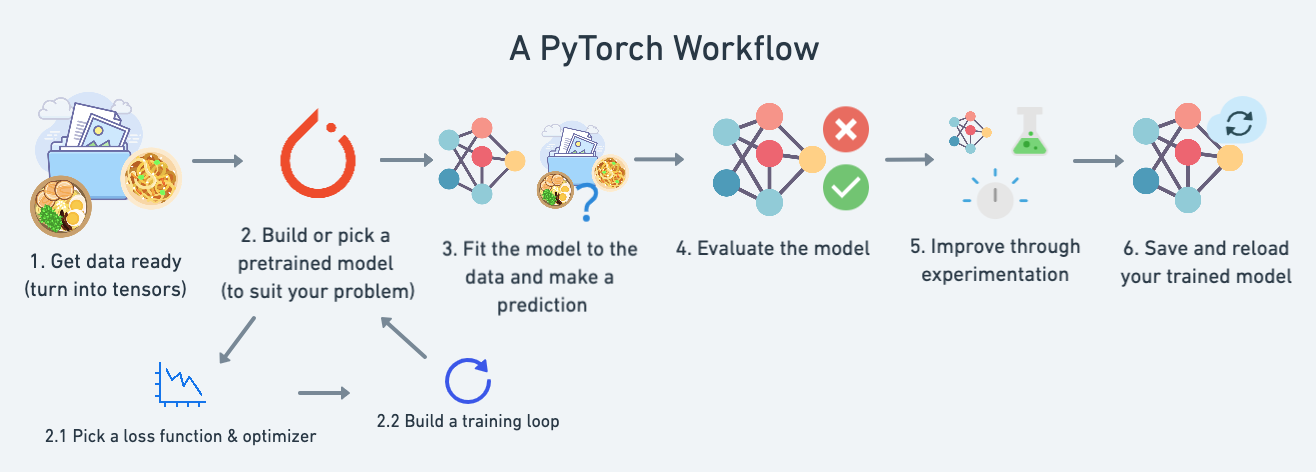

In this MP, you will mostly work on the second step: *__building a model__*.

<a id='section2'></a>
## Datasets

The dataset consists of `3750` 31x31 colored (RGB) images (a modified subset of the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), provided by Alex Krizhevsky). This set is split for you into `2813` training examples and `937` test examples.

In this MP, data processing is taken care of for you. The **helper.py** is provided as utility to facilitate the data loading process. You can ignore the implementation details in **helper.py**.

To use **helper.py**, you need to have **numpy** and **matplotlib** installed.

The function `Load_dataset()` unpacks the dataset file (*you don't need to call this function in the submitted.py*), returning images and labels for the training and test sets. Note that the images have been flattened, therefore the dimension of one image sample is `2883` (31 x 31 x 3).

In [3]:
import helper

filepath = "./data/mp_data"
# load datasets, you don't need to call this function in the MP
train_set, train_labels, test_set, test_labels = helper.Load_dataset(filepath)
print("Shape of train set:", train_set.shape)
print("Shape of test set:", test_set.shape)

Shape of train set: (2813, 2883)
Shape of test set: (937, 2883)


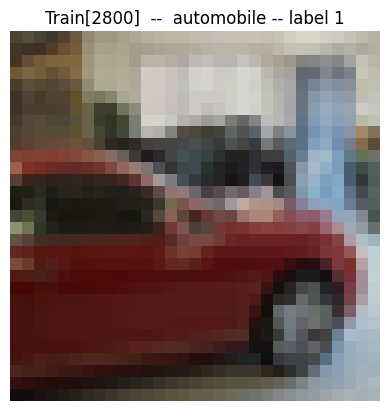

In [5]:
# Use the helper function to visualize training set.
# The third argument is the index of image to visualize.
# Feel free to change the index. Note that the size of training set is 2813
helper.show_train_image(train_set, train_labels, 2800)

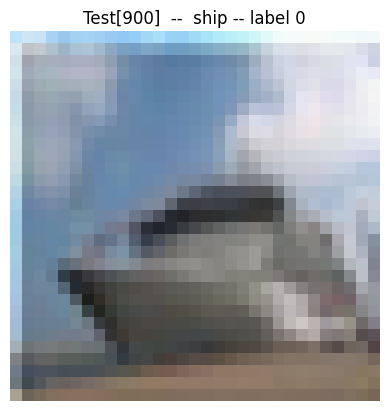

In [7]:
# Use the helper function to visualize testing set.
# The third argument is the index of image to visualize.
# Feel free to change the index. Note that the size of testing size is 937
helper.show_test_image(test_set, test_labels, 900)

<a id='section3'></a>
## Dataloaders

__Source__: [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

Code for processing data samples can get messy and hard to maintain; we ideally want our data processing code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html) and [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

A dataloader is a way for you to handle loading and transforming data before it enters your network for training or prediction. It lets you write code that looks like you're just looping through the dataset, with the division into batches happening automatically. In this MP, you **don't need to write the dataset and dataloader** part, we have provided one for you, but you need to understand how to use it.

For more information about datasets and dataloaders, please refer to __Source__.

In [8]:
# Use provided helper function to generate dataloaders
# You don't need to call these functions in submitted.py

# Preprocess the datasets
train_set_processed, test_set_processed = helper.Preprocess(train_set, test_set)

# Generate dataloaders
train_loader, test_loader = helper.Get_DataLoaders(
    train_set_processed,
    train_labels,
    test_set_processed,
    test_labels,
    batch_size=100,
)

Each iteration below returns a batch of `train_features` and `train_labels` (in this MP, we set up batch size equal to 100, so each batch contains 100 feature and label tensors respectively). You can pass the feature batch to your neural network, and then compare the label batch with your predictions. Let's iterate over the dataset and see what each batch looks like.

Labels:   
`ship: 0, automobile: 1, dog: 2, frog: 3, horse: 4`

In [9]:
batch_index = 0

# Iterate over the first 3 batches
for features, labels in train_loader:
    print("Batch #", batch_index)
    print("Features shape:", features.shape)
    print(features, "\n")
    print("Labels shape:", labels.shape)
    print(labels, "\n\n")
    batch_index += 1
    if batch_index == 3:
        break

Batch # 0
Features shape: torch.Size([100, 2883])
tensor([[ 0.3525,  0.3150, -0.6970,  ...,  1.2380,  1.2221,  1.3589],
        [ 0.8684,  0.9081,  0.9093,  ...,  1.0154,  1.0167,  0.9519],
        [ 0.3932,  0.3839, -0.2262,  ..., -0.6230, -0.5951, -0.5977],
        ...,
        [-0.4756,  0.1494,  0.5631,  ..., -0.6230, -0.7689, -1.1299],
        [ 1.4793,  1.5012,  1.5324,  ...,  0.9199,  0.9219,  0.8737],
        [-0.5027, -0.5816, -0.5309,  ...,  1.0631,  1.0483,  0.9989]]) 

Labels shape: torch.Size([100])
tensor([0, 0, 0, 3, 1, 1, 0, 1, 4, 4, 4, 2, 1, 0, 3, 4, 1, 1, 3, 1, 1, 4, 1, 1,
        4, 4, 3, 2, 0, 4, 2, 1, 0, 1, 0, 3, 0, 1, 0, 4, 4, 0, 4, 0, 3, 2, 2, 3,
        4, 2, 3, 3, 1, 2, 3, 3, 2, 2, 2, 2, 1, 0, 4, 0, 3, 3, 0, 3, 1, 0, 0, 2,
        1, 3, 0, 0, 2, 4, 3, 2, 3, 2, 2, 3, 3, 2, 0, 3, 4, 0, 1, 0, 3, 1, 0, 0,
        4, 2, 0, 1]) 


Batch # 1
Features shape: torch.Size([100, 2883])
tensor([[-1.7381, -1.7541, -1.7771,  ..., -1.7523, -1.7487, -1.7403],
        [-0.3127, 

Each batch contains features and labels. The features are tensors with shape `(batch_size, feature_size)`, and the labels are tensors with shape `(batch_size)`.

<a id='section4'></a>
## Tensors

__Source__: [mrdbourke/pytorch-deep-learning](https://www.learnpytorch.io/00_pytorch_fundamentals/#introduction-to-tensors)

Tensors are a specialized data structure that are very similar to numpy arrays and matrices. Their job is to represent data in a numerical way. Tensors are similar to NumPy’s arrays, except that tensors can run on GPUs or other hardware accelerators (better performance!). In PyTorch, we use tensors to encode the inputs and outputs of a model, as well as the model’s parameters.

The code cell below may give you some idea of how to use tensors.

In [10]:
rand_tensor = torch.rand(2, 3)              # create a random tensor of size (2, 3)
zeros_tensor = torch.zeros(5)               # create a tensor of size 5 that is filled with 0's
print("Random Tensor: \n", rand_tensor, "\n")
print("Zeros Tensor: \n", zeros_tensor, "\n")

# explore some of the attributes of a Tensor
tensor = torch.tensor([[7, 7, 5], [1, 3, 0], [2, 2, 1], [9, 4, 8]])
print("My Tensor: \n", tensor)
print("Shape of tensor: ", tensor.shape)
print("Datatype of tensor: ", tensor.dtype)
print("Device tensor is stored on: ", tensor.device, "\n")

# element-wise multiplication
tensor1 = torch.tensor([1, 2, 3])
tensor2 = torch.tensor([2, 3, 4])
print("Element-wise multiplication:")
print(tensor1, "*", tensor2, "=", tensor1 * tensor2)

Random Tensor: 
 tensor([[0.7851, 0.4023, 0.3731],
        [0.9697, 0.2283, 0.3253]]) 

Zeros Tensor: 
 tensor([0., 0., 0., 0., 0.]) 

My Tensor: 
 tensor([[7, 7, 5],
        [1, 3, 0],
        [2, 2, 1],
        [9, 4, 8]])
Shape of tensor:  torch.Size([4, 3])
Datatype of tensor:  torch.int64
Device tensor is stored on:  cpu 

Element-wise multiplication:
tensor([1, 2, 3]) * tensor([2, 3, 4]) = tensor([ 2,  6, 12])


One of the most common errors you'll run into in deep learning is shape mismatches, because matrix multiplication has a strict rule about what shapes and sizes can be combined.

The code cell below is such an example.

In [11]:
# matrix multiplication
tensor_A = torch.tensor([[1, 2],
                         [3, 4],
                         [5, 6]], dtype=torch.float32)

tensor_B = torch.tensor([[7, 10],
                         [8, 11],
                         [9, 12]], dtype=torch.float32)
print("tensor_A, shape =", tensor_A.shape)
print(tensor_A, "\n")
print("tensor_B, shape =", tensor_B.shape)
print(tensor_B)

# torch.matmul() is a built-in matrix multiplication function
torch.matmul(tensor_A, tensor_B)    # this will error because of shape mismatch

tensor_A, shape = torch.Size([3, 2])
tensor([[1., 2.],
        [3., 4.],
        [5., 6.]]) 

tensor_B, shape = torch.Size([3, 2])
tensor([[ 7., 10.],
        [ 8., 11.],
        [ 9., 12.]])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x2 and 3x2)

In [12]:
# tensor_A and tensor_B cannot be multiplied
# However, multiplying tensor_A with the transpose of tensor_B is legal (3x2 and 2x3)
# transpose of a tensor:    tensor.T - where tensor is the desired tensor to transpose
print("tensor_A, shape =", tensor_A.shape)
print(tensor_A, "\n")
print("transpose of tensor_B, shape =", tensor_B.T.shape)
print(tensor_B.T, "\n")         # transpose of tensor_B
print("tensor_A * tensor_B.T equals")
print(torch.matmul(tensor_A, tensor_B.T))

tensor_A, shape = torch.Size([3, 2])
tensor([[1., 2.],
        [3., 4.],
        [5., 6.]]) 

transpose of tensor_B, shape = torch.Size([2, 3])
tensor([[ 7.,  8.,  9.],
        [10., 11., 12.]]) 

tensor_A * tensor_B.T equals
tensor([[ 27.,  30.,  33.],
        [ 61.,  68.,  75.],
        [ 95., 106., 117.]])


<a id='section5'></a>
## Neural Net Layers

So far we have looked into the tensors, their properties and basic operations on tensors. These are especially useful to get familiar with if we are building the layers of our network from scratch. PyTorch also provides some built-in blocks in the [torch.nn](https://pytorch.org/docs/stable/nn.html) module.

We can use [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)(in_features, out_features) to create a a linear layer that applies a linear transformation to the incoming data x:  
- y = x $A^{T}$  + b ,  where A and b are initialized __randomly__.

This will take an input of size (∗, *__in_features__*) where ∗ means any number of dimensions including none and *__in_features__* is the size of each input sample. It will yield an output of size (∗, *__out_features__*) where all but the last dimension are the same shape as the input and *__out_features__* is the size of each output sample. 

In [13]:
# Create the input (8 samples, each of size 5)
input = torch.randn(8, 5)
print("Input:")
print(input)
print("Input size:", input.size(), "\n")

# Make a linear layer transforming (*, 5)-dimensinal inputs to (*, 7)-dimensional outputs
linear_layer = torch.nn.Linear(5, 7)

# Apply the linear layer
output = linear_layer(input)
print("Output:")
print(output)
print("Output size:", output.size())

Input:
tensor([[ 0.0773, -0.2633,  0.3509,  0.5581,  1.2969],
        [-0.1074,  1.3704, -0.8940, -0.0701, -0.0437],
        [ 0.6369,  0.0886, -0.0131,  0.1215, -0.3428],
        [-0.1726, -1.9484,  0.2684, -0.3400,  0.1273],
        [ 0.4055, -2.2310,  1.0291,  0.5169,  3.2442],
        [-0.9416, -0.1985,  1.2173,  0.2519, -0.6050],
        [-1.1530, -1.1303,  0.5179, -1.0624,  2.6243],
        [ 0.8054, -0.4445, -0.2814, -0.1295,  0.0440]])
Input size: torch.Size([8, 5]) 

Output:
tensor([[-0.7726, -0.8100, -0.4222, -0.0237,  0.4877, -0.0459, -0.4751],
        [ 0.0284, -0.7138, -0.1456,  0.2320,  0.9216,  0.6100,  0.2423],
        [ 0.2298, -0.5160,  0.1174, -0.3870,  0.2522, -0.3709,  0.2122],
        [-0.3402,  0.4998, -0.2000, -0.5200, -0.5492, -0.7251, -0.5208],
        [-1.6603, -0.7328, -0.5520,  0.1707,  0.4070, -0.4745, -1.3682],
        [-0.0080,  0.1282, -0.3761, -0.9825, -0.5874, -0.1444, -0.4293],
        [-1.1009,  0.2048, -0.4592,  0.4320,  0.6019,  0.9029, -1.6560],


We can also use the torch.nn module to apply activations functions to our tensors. Activation functions are used to add non-linearity to our network. Activation functions operate on each element seperately, so the shape of the tensors we get as an output are the same as the ones we pass in. Let's try [nn.Sigmoid()](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html).

In [14]:
# Pass the output of previous layer to the current layer as the input
print("Previous output:")
print(output)
print("Output size:", output.size(), "\n")

# Create a sigmoid function
sigmoid = torch.nn.Sigmoid()

# Apply the activation function
activated_output = sigmoid(output)
print("Activated output:")
print(activated_output)
print("Activated output size:", activated_output.size())

Previous output:
tensor([[-0.7726, -0.8100, -0.4222, -0.0237,  0.4877, -0.0459, -0.4751],
        [ 0.0284, -0.7138, -0.1456,  0.2320,  0.9216,  0.6100,  0.2423],
        [ 0.2298, -0.5160,  0.1174, -0.3870,  0.2522, -0.3709,  0.2122],
        [-0.3402,  0.4998, -0.2000, -0.5200, -0.5492, -0.7251, -0.5208],
        [-1.6603, -0.7328, -0.5520,  0.1707,  0.4070, -0.4745, -1.3682],
        [-0.0080,  0.1282, -0.3761, -0.9825, -0.5874, -0.1444, -0.4293],
        [-1.1009,  0.2048, -0.4592,  0.4320,  0.6019,  0.9029, -1.6560],
        [ 0.0789, -0.3941,  0.1587, -0.1896,  0.3201, -0.4563,  0.0981]],
       grad_fn=<AddmmBackward0>)
Output size: torch.Size([8, 7]) 

Activated output:
tensor([[0.3159, 0.3079, 0.3960, 0.4941, 0.6196, 0.4885, 0.3834],
        [0.5071, 0.3288, 0.4637, 0.5577, 0.7154, 0.6479, 0.5603],
        [0.5572, 0.3738, 0.5293, 0.4044, 0.5627, 0.4083, 0.5528],
        [0.4158, 0.6224, 0.4502, 0.3729, 0.3661, 0.3263, 0.3727],
        [0.1597, 0.3246, 0.3654, 0.5426, 0.6004, 

So far we have seen that we can create layers and pass the output of one as the input of the next. Instead of creating intermediate tensors and passing them around, we can use [nn.Sequentual](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html), which does exactly that.

In [15]:
# Create a sequential container
block = torch.nn.Sequential(
    torch.nn.Linear(5, 7),
    torch.nn.Sigmoid()
)

print("Input:")
print(input)
print("Input size:", input.size(), "\n")

# Apply the block
block_output = block(input)
print("Block output:")
print(block_output)
print("Block output size:", block_output.size())

Input:
tensor([[ 0.0773, -0.2633,  0.3509,  0.5581,  1.2969],
        [-0.1074,  1.3704, -0.8940, -0.0701, -0.0437],
        [ 0.6369,  0.0886, -0.0131,  0.1215, -0.3428],
        [-0.1726, -1.9484,  0.2684, -0.3400,  0.1273],
        [ 0.4055, -2.2310,  1.0291,  0.5169,  3.2442],
        [-0.9416, -0.1985,  1.2173,  0.2519, -0.6050],
        [-1.1530, -1.1303,  0.5179, -1.0624,  2.6243],
        [ 0.8054, -0.4445, -0.2814, -0.1295,  0.0440]])
Input size: torch.Size([8, 5]) 

Block output:
tensor([[0.5737, 0.6843, 0.3260, 0.7040, 0.6089, 0.5852, 0.5081],
        [0.5884, 0.6937, 0.4924, 0.5138, 0.6141, 0.6633, 0.2967],
        [0.5949, 0.6165, 0.5182, 0.6067, 0.6082, 0.4903, 0.5795],
        [0.4852, 0.4250, 0.4524, 0.5761, 0.4782, 0.3088, 0.7335],
        [0.5517, 0.6421, 0.1667, 0.7869, 0.6073, 0.4822, 0.6718],
        [0.4560, 0.5141, 0.5622, 0.6970, 0.4560, 0.3930, 0.6565],
        [0.4046, 0.5017, 0.2800, 0.6196, 0.4631, 0.4237, 0.4606],
        [0.5962, 0.5893, 0.4727, 0.5688, 0.

Note the output values produced by the two methods are not the same, because the weights and biases were initialized randomly. But the shape of the output tensors are the same.

<a id='section6'></a>
## You need to implement this (1)

Implement the `create_sequential_layers()` function in the `submitted.py` file. This function should return a `nn.Sequential` object.

Once you have implemented the function, you can run the code cell below to test your implementation.

In [17]:
!python -m unittest tests.test_visible.Test.test_sequential_layers

.
----------------------------------------------------------------------
Ran 1 test in 0.062s

OK


<a id='section7'></a>
## Build a Model
__Source__: [mrdbourke/pytorch-deep-learning](https://www.learnpytorch.io/01_pytorch_workflow/#2-build-model) and [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)


Now that we have covered some fundamentals, let's focus on how to build a model. In this MP, you will implement a neural network.

Neural networks comprise of layers/modules that perform operations on data. The [torch.nn](https://pytorch.org/docs/stable/nn.html) (a PyTorch module) namespace provides all the building blocks you need to build your own neural network. Every module in PyTorch subclasses the [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) (object-oriented programming -- if you are not familar with Python class notation, or if you don't quite understand what it means, you may want to take a look at [this](https://realpython.com/python3-object-oriented-programming/)). A neural network is a derived class of nn.Module that consists of other modules (layers). This nested structure allows for building and managing complex architectures easily.

The neural network model is defined in two steps: 
1. we first specify the parameters (e.g., layers) of the model ( in `__init__()` ), 

2. and then outline how they are applied to the inputs ( in `forward()` ).

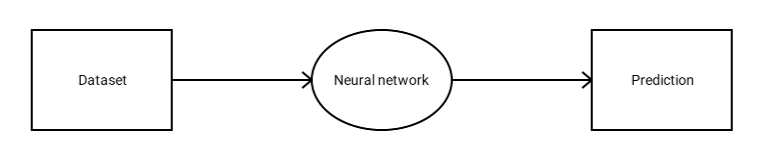

The code snippet provided below is a simple example of how to construct a network and use it to make a prediction. Note that there are *__more than one way__* to construct a network architecture, you can find many examples on the internet.

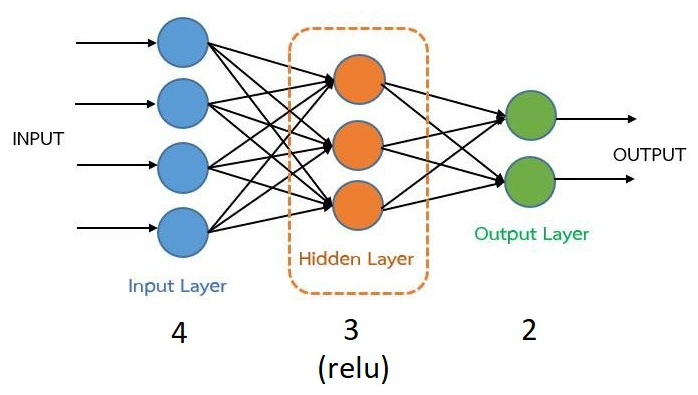

In [18]:
import torch

class SimpleNet(torch.nn.Module):
  def __init__(self):
    """
    In the initialization function we specify the parameters of our network.
    """
    super().__init__()  # call the initialization function of the base class (nn.Module)
    # network architecture, please try to relate the code to the picture
    self.hidden = torch.nn.Linear(4, 3)  # input has 4 values
    self.relu = torch.nn.ReLU()  # activation function
    self.output = torch.nn.Linear(3, 2)  # output has 2 values

  def forward(self, x):
    """
    In the forward function we accept a Tensor of input data (the variable x) and we must return a Tensor of output data.
    We can use Modules defined in the __init__() as well as arbitrary (differentiable) operations on Tensors.
    """
    x_temp = self.hidden(x)             # input data x flows through the hidden layer
    x_temp = self.relu(x_temp)          # use relu as the activation function for intermediate data
    y_pred = self.output(x_temp)        # predicted value
    return y_pred

# Create an instance of the SimpleNet model (this is a subclass of nn.Module)
model = SimpleNet()

# Create inputs, here we use a random tensor, but in reality, the input should be loaded from a real-world dataset
x = torch.rand(3, 4)   # 3 samples, each sample of size 4

# Forward pass: compute predicted y by passing x to the model
# Note that the model is randomly initialized, so this prediction probably doesn't make sense
# We need to train our model and teach it to make reasonable predictions (we will see that later)
y_pred = model(x)

print("y_pred.shape: ", y_pred.shape)   # since our output layer has 2 values, y_pred should be of size (3, 2)
print(y_pred)

y_pred.shape:  torch.Size([3, 2])
tensor([[ 0.4146, -0.5166],
        [ 0.3701, -0.4862],
        [ 0.3744, -0.4891]], grad_fn=<AddmmBackward0>)


| Name | What does it do? |
| ----- | ----- |
| [`torch.nn`](https://pytorch.org/docs/stable/nn.html) | Contains all of the building blocks (network layers) for computational graphs (essentially a series of computations executed in a particular way). |
| [`torch.nn.Module`](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) | The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass `nn.Module`. Requires a `forward()` method be implemented. | 
| `__init__()` | `__init__()` is your network's initialization function, where you will initialize the neural network layers.|
| `forward()` | All `nn.Module` subclasses (e.g., your own network) require a `forward()` method, this defines the computation that will take place on the data passed to the particular `nn.Module`. Simply put, `forward()` should perform a forward pass through your network. Note that you should *__NOT__* directly call the `forward(x)` method, though. To use the model, you should call the whole model itself and pass it the input data, as in `model(x)` to perform a forward pass and output predictions. This executes the model's `forward()` automatically.  |
| [`torch.optim`](https://pytorch.org/docs/stable/optim.html) | Contains various optimization algorithms (these tell the model parameters stored in `nn.Parameter` how to best change to improve gradient descent and in turn reduce the loss). | 

<a id='section8'></a>
## Train a Model
__Source__: [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)

Training a model is an iterative process; in each iteration the model makes a guess about the output, calculates the error in its guess (loss), collects the derivatives of the error with respect to its parameters, and optimizes these parameters using gradient descent.

Note that the parameters are initialized randomly, and for our model to update its parameters on its own, we'll need to add a *__loss function__* as well as an *__optimizer__*.

#### *Loss Function and Optimizer*

| Function | What does it do? | Where does it live in PyTorch? | Common values |
| ----- | ----- | ----- | ----- |
| **Loss function** | Measures how wrong your models predictions (e.g. `y_preds`) are compared to the truth labels (e.g. `y_test`). Lower the better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean absolute error (MAE) for regression problems ([`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)). Binary cross entropy for binary classification problems ([`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html)).  Cross entropy for multi-class classification problems ([`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic gradient descent ([`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD)). Adam optimizer ([`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)). |

<a id='section9'></a>
## You need to implement this (2)

Implement the `create_loss_function()` function in the `submitted.py` file. This function should return a loss object that is suitable for the classification problem.

Once you have implemented the function, you can run the code cell below to test your implementation.

In [19]:
!python -m unittest tests.test_visible.Test.test_loss_fn

.
----------------------------------------------------------------------
Ran 1 test in 0.065s

OK


<a id='section10'></a>
## *Gradients*
When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights, biases, ...) are adjusted according to the gradient of the loss function with respect to the given parameter. To compute those gradients, PyTorch has a built-in differentiation engine called `torch.autograd`. It supports automatic computation of gradient for any computational graph. Take a look at [this](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html) for more information about autogradient in PyTorch (you should be able to understand everything that is covered in the linked tutorial by now).

Time for an example:

In [20]:
y_pred = model(x)
print("Predicted values:")
print(y_pred, "\n")

# Create a loss function, e.g., Mean Squared Error
loss_fn = torch.nn.MSELoss()

# Make up some true values, in reality, they should come from a real-world dataset
y_true = torch.tensor(
    [
        [1, 1],
        [1, 1],
        [1, 1]
    ], dtype=torch.float32)
print("True values:")
print(y_true, "\n")

# Calculate MSE
loss = loss_fn(y_pred, y_true)
print("MSE:", loss, "\n\n\n")       # You can verify the results manually


# Create an optimizer, e.g., SGD optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=1)
# params:   parameters of target model to optimize
# lr:       learning rate (how much the optimizer should change parameters at each step)

print("Weights of hidden linear layer, before back propagation:")
print(model.hidden.weight, "\n")

# Preform back propagation
optimizer.zero_grad()   # Clear previous gradients, will see more about this later
loss.backward()         # back propagation
# Here we only print the gradients of hidden.weight,
# but backward() updates gradients of all related parameters
print("gradients of weights of the hidden layer:")
print(model.hidden.weight.grad, "\n")

# Update parameters
optimizer.step()
print("Weights of hidden linear layer, after back propagation:")
print(model.hidden.weight) # You can verify the results, after = before - gradient x learning rate.

Predicted values:
tensor([[ 0.4146, -0.5166],
        [ 0.3701, -0.4862],
        [ 0.3744, -0.4891]], grad_fn=<AddmmBackward0>) 

True values:
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]]) 

MSE: tensor(1.3095, grad_fn=<MseLossBackward0>) 



Weights of hidden linear layer, before back propagation:
Parameter containing:
tensor([[-0.2695, -0.0113,  0.2043, -0.0964],
        [ 0.0785,  0.4051, -0.4862,  0.1375],
        [-0.0199,  0.2015, -0.2558,  0.1375]], requires_grad=True) 

gradients of weights of the hidden layer:
tensor([[-0.0394, -0.0962, -0.0360, -0.0718],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000]]) 

Weights of hidden linear layer, after back propagation:
Parameter containing:
tensor([[-0.2301,  0.0849,  0.2403, -0.0246],
        [ 0.0785,  0.4051, -0.4862,  0.1375],
        [-0.0199,  0.2015, -0.2558,  0.1375]], requires_grad=True)


#### *Hyperparameters*
Hyperparameters are adjustable parameters that let you control the model optimization process. Different hyperparameter values can impact model training and convergence rates.

We define the following hyperparameters for training:
- *__Number of Epochs__* - the number of times to iterate over the dataset (one epoch = one forward pass and one backward pass of all the training samples)

- *__Batch Size__* - the number of data samples propagated through the network before the parameters are updated

- *__Learning Rate__* - how much to update models parameters at each batch/epoch. Smaller values yield slow learning speed, while large values may result in unpredictable behavior during training.

#### *Batch size*
Batch size might be confusing if this is your first time hearing it. You can find a wonderful explanation [here](https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network#:~:text=Advantages%20of%20using%20a%20batch%20size%20%3C%20number,we%20update%20the%20weights%20after%20each%20propagation.%20).

> Let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through of the network. Problem might happen with the last set of samples. In our example, we've used 1050 which is not divisible by 100 without remainder. The simplest solution is just to get the final 50 samples and train the network.
>
> Advantages of using a batch size < number of all samples:
> - It requires less memory. Since you train the network using fewer samples, the overall training procedure requires less memory. That's especially important if you are not able to fit the whole dataset in your machine's memory.
>
> - Typically networks train faster with mini-batches. That's because we update the weights after each propagation. In our example we've propagated 11 batches (10 of them had 100 samples and 1 had 50 samples) and after each of them we've updated our network's parameters. If we used all samples during propagation we would make only 1 update for the network's parameter.
>
> Disadvantages of using a batch size < number of all samples:
> - The smaller the batch the less accurate the estimate of the gradient will be.

#### *Annotated Code*
Please note that the code snippets below do not make use of batch size, instead it uses one single "batch" with all training data. Take a look [here](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html) for an example with batch size. In this MP, you will write a training loop which operates data in batches i.e., using dataloaders.

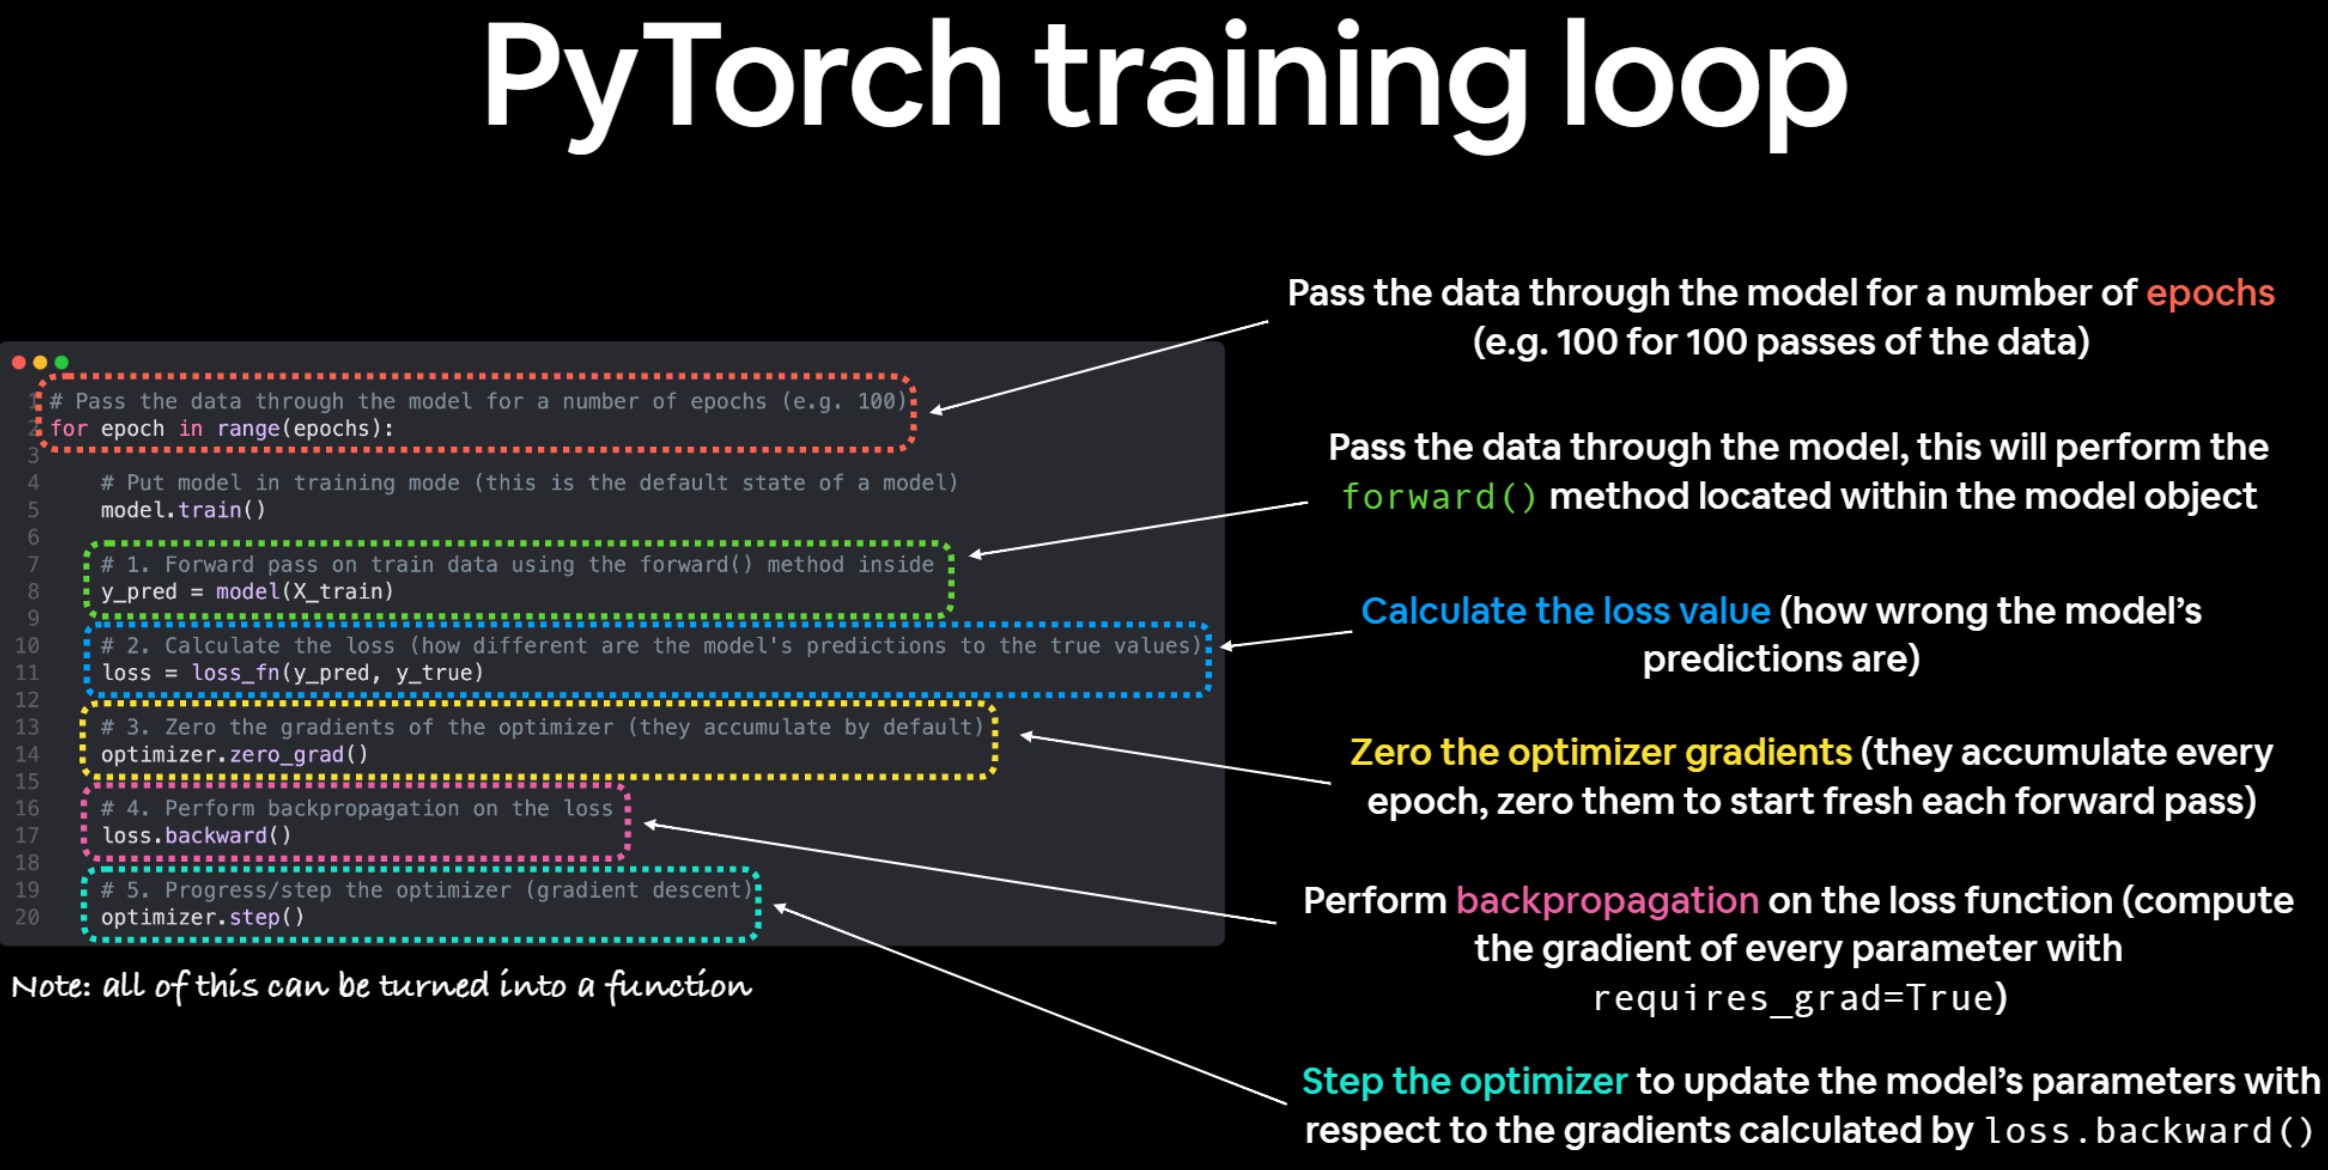

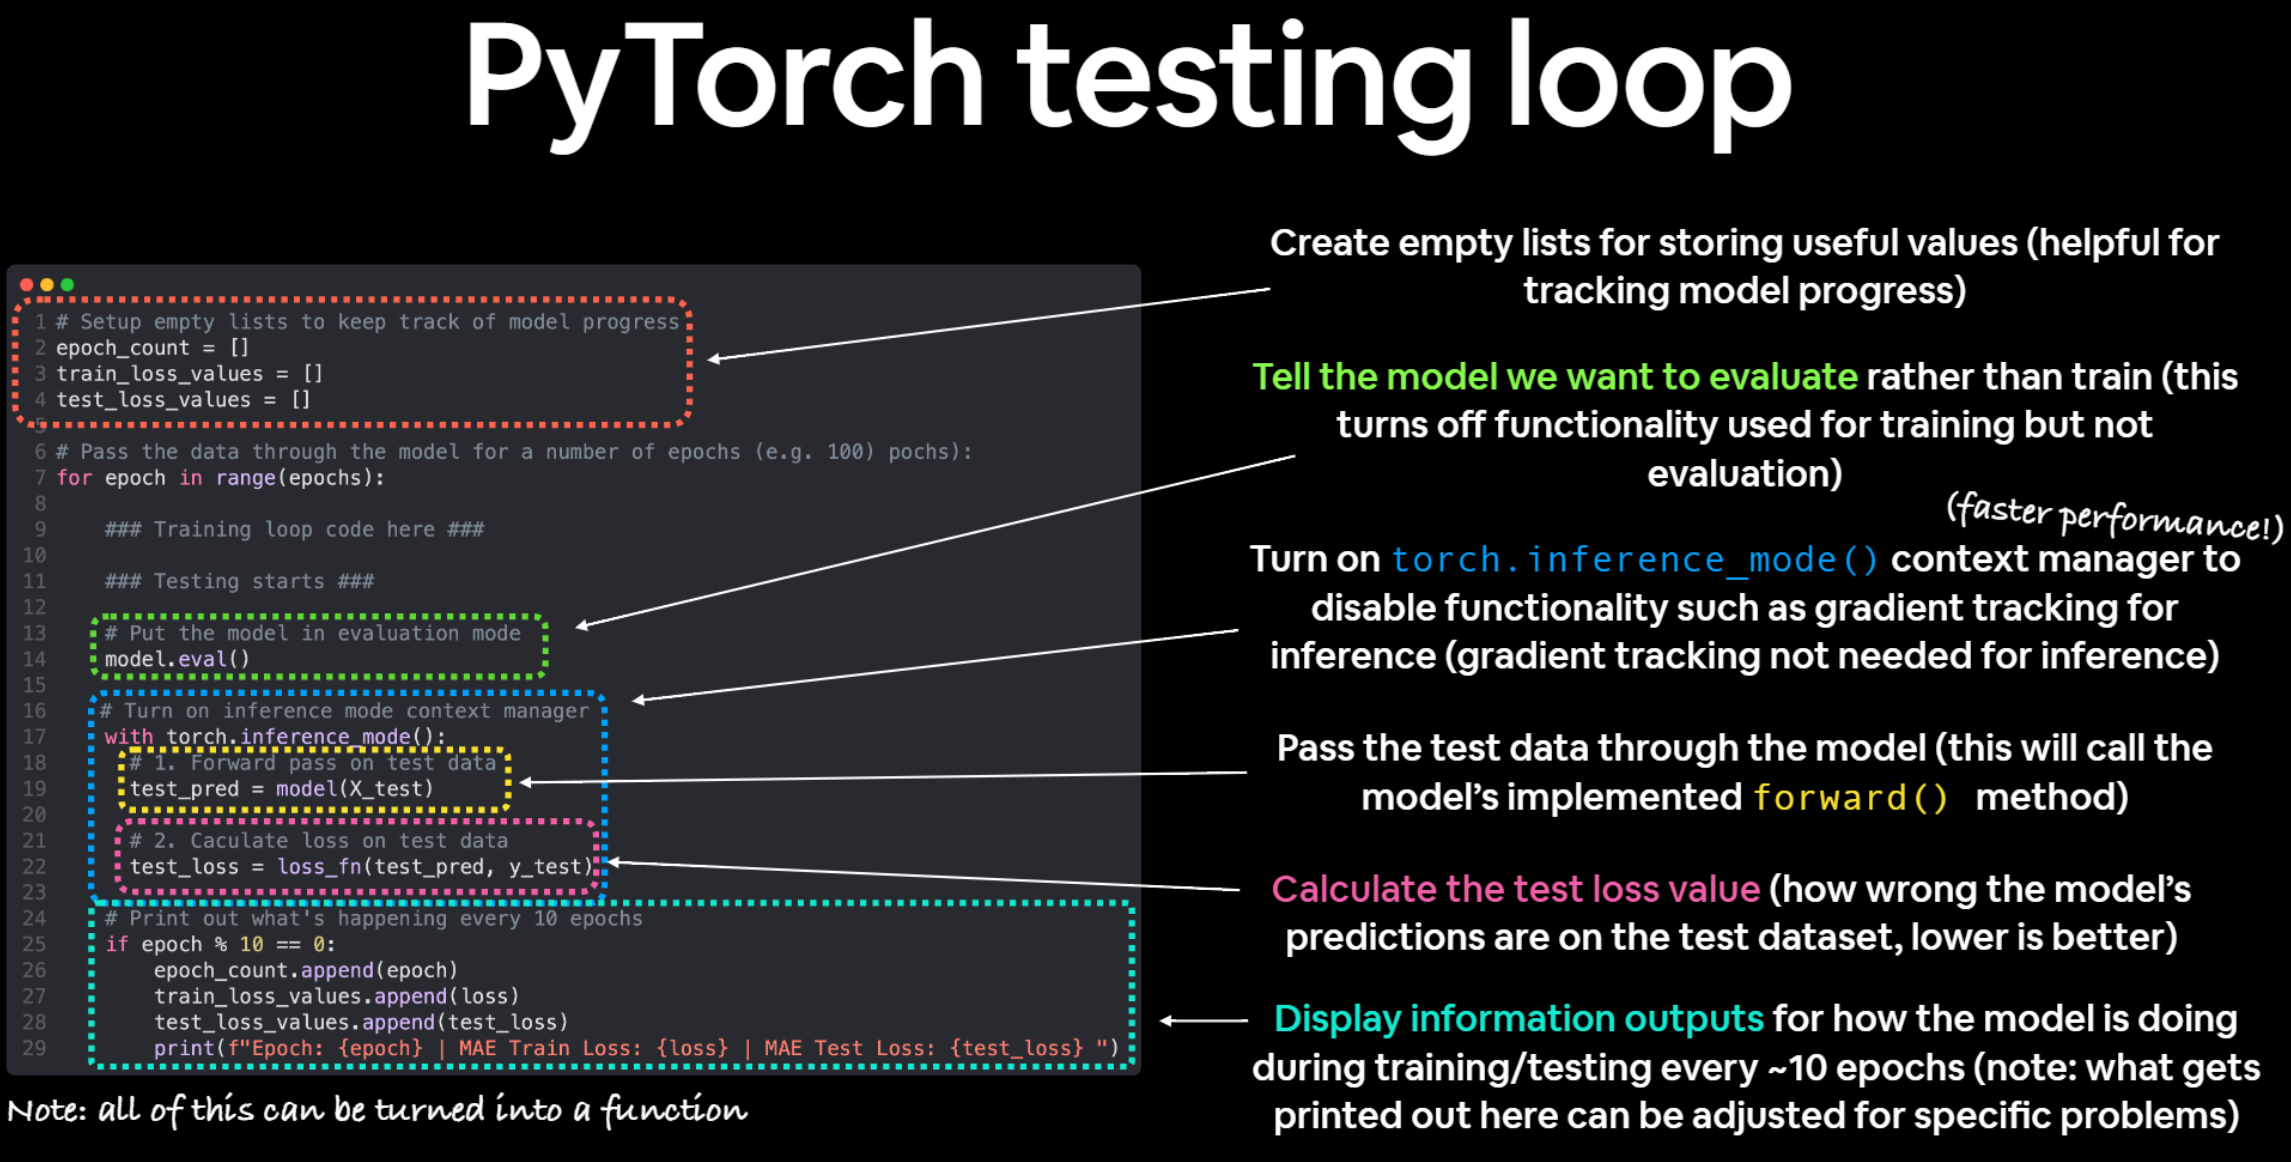

<a id='section11'></a>
## You need to implement this (3)

Now it's time for you to create a neural network. You will implement a neural network in `Class NeuralNet` and write a training loop in the function `train()`.

*__In each training iteration, the input of your network is a batch of preprocessed image data of size (batch size, 2883). The number of neurons in the output layer should be equal to the number of categories.  
For this assignment, you should use [Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Notice that because PyTorch's CrossEntropyLoss incorporates a softmax function, you do not need to explicitly include an normalization function in the last layer of your network__*.

To get a full score, the accuracy of your network must be above `0.61 on the visible testing set`, and `above 0.57 on the hidden testing set`. The structure of the neural network is completely up to you. You should be able to get around 0.62 testing-set accuracy with a two-layer network with no more than 200 hidden neurons.

If you are confident about a model you have implemented but are not able to pass the accuracy thresholds on gradescope, try adjusting the learning rate. Be aware, however, that using a very high learning rate may worse performance since the model may begin to oscillate around the optimal parameter settings.

Once you have implemented the function, you can run the code cell below to test your implementation.

In [144]:
!python grade.py

Total number of network parameters:  96671

 Accuracy: 0.7086446104589115

Confusion Matrix = 
 [[158.  19.   4.   3.   6.]
 [ 44. 128.   6.  15.   9.]
 [  8.   5. 124.  24.  25.]
 [  6.   6.  17. 146.  11.]
 [ 10.   8.  35.  12. 108.]]
+5 points for accuracy above 0.15
+5 points for accuracy above 0.25
+5 points for accuracy above 0.48
+5 points for accuracy above 0.55
+5 points for accuracy above 0.57
+5 points for accuracy above 0.61


...
----------------------------------------------------------------------
Ran 3 tests in 16.667s

OK


<a id='extra'></a>
## Extra credit

You can earn extra credits worth 10% of this MP if the accuracy of your network is above `0.66`

### Some tips:
1. Choose a good activation function.
2. L2 Regularization.
3. Convolutional neural network.